# Zillow 

## Goal:

    To make a regression model that can best fit the tax amount of properties.
    To identify the three counties where these properties are located
        
## Executive summary: 

    - Polynomial Regression was the best model with R^2 value of 0.3586
    - Too many missing values in the data to be of use. 
    - The three counties where these properties are located
        - 0611 Ventura County
        - 0637 Los Angeles County
        - 0659 Orange County

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data getting, cleaning, and exploring

from env import user, password, host
import features
# Python without these is hard
import pandas as pd
import numpy as np
from pydataset import data
from scipy import stats

# Machine Learning
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.impute import SimpleImputer
# Regression Modeling
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Acquire 

In [3]:
url = f"mysql+pymysql://{user}:{password}@{host}/zillow"
    
query = """SELECT 
                parcelid, 
                bathroomcnt as bathroom , 
                bedroomcnt as bedroom,
                calculatedfinishedsquarefeet as area, 
                fips, 
                taxvaluedollarcnt as tax,
                yearbuilt as year 
                FROM properties_2017
                JOIN predictions_2017
                USING (parcelid)
                JOIN propertylandusetype
                USING (propertylandusetypeid)
                WHERE propertylandusedesc IN ("Single Family Residential",                       
                              "Inferred Single Family Residential") AND
                              (transactiondate BETWEEN "2017-01-01" AND "2017-12-31")
"""

In [4]:
df = pd.read_sql(query, url)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   parcelid  52441 non-null  int64  
 1   bathroom  52441 non-null  float64
 2   bedroom   52441 non-null  float64
 3   area      52359 non-null  float64
 4   fips      52441 non-null  float64
 5   tax       52440 non-null  float64
 6   year      52325 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 2.8 MB


In [6]:
df.describe()

,parcelid,bathroom,bedroom,area,fips,tax,year
count,5.244100e+04,52441.000000,52441.000000,52359.000000,52441.000000,5.244000e+04,52325.000000
mean,1.299912e+07,2.299403,3.300681,1922.890754,6049.132149,5.296882e+05,1963.393884
std,3.411444e+06,1.022772,0.949094,1004.365838,21.029067,7.518946e+05,23.133571
min,1.071186e+07,0.000000,0.000000,128.000000,6037.000000,1.000000e+03,1878.000000
25%,1.151022e+07,2.000000,3.000000,1268.000000,6037.000000,1.937475e+05,1950.000000
50%,1.257764e+07,2.000000,3.000000,1659.000000,6037.000000,3.736120e+05,1961.000000
75%,1.412953e+07,3.000000,4.000000,2306.000000,6059.000000,6.193012e+05,1979.000000
max,1.676878e+08,18.000000,14.000000,21929.000000,6111.000000,4.906124e+07,2016.000000


### Takeways:
- Some missing values
- Bedroom Outliers(14)
- Bathroom Outliers(18)
- Area outliers 

### EDA

In [7]:
# What is the proportion of the missing values?
round(df.dropna().shape[0] / df.shape[0], 4)

0.9977

In [8]:
# Drop missing values
df = df.dropna()

In [9]:
df.head()

,parcelid,bathroom,bedroom,area,fips,tax,year
0,14297519,3.5,4.0,3100.0,6059.0,1023282.0,1998.0
1,17052889,1.0,2.0,1465.0,6111.0,464000.0,1967.0
2,14186244,2.0,3.0,1243.0,6059.0,564778.0,1962.0
3,12177905,3.0,4.0,2376.0,6037.0,145143.0,1970.0
4,12095076,3.0,4.0,2962.0,6037.0,773303.0,1950.0


In [10]:
# How much of the data has less than 7 bathrooms?
df[df.bathroom <= 6].shape[0]/df.shape[0]

0.9956230050268545

In [11]:
# How much of the data has less than 7 bedrooms?
df[df.bedroom <= 6].shape[0]/df.shape[0]

0.9972285403008467

In [12]:
# How much of the properties are valued more than 1.5 mil?
df[df.tax <= 1_500_000].shape[0]/df.shape[0]

0.9517001471740668

In [13]:
drop = df[(df['bathroom'] >= 6) & (df['bedroom'] >= 6) & (df['tax'] >= 1_500_000)].index

In [ ]:
df.drop(drop, inplace=True)

### Takeaways:
- Dropped properties with more than 6 bathrooms and bedrooms because they are outliers
- Dropped properties more than 1.5 million square ft because it is an outlier

In [15]:
df.head()

,parcelid,bathroom,bedroom,area,fips,tax,year
0,14297519,3.5,4.0,3100.0,6059.0,1023282.0,1998.0
1,17052889,1.0,2.0,1465.0,6111.0,464000.0,1967.0
2,14186244,2.0,3.0,1243.0,6059.0,564778.0,1962.0
3,12177905,3.0,4.0,2376.0,6037.0,145143.0,1970.0
4,12095076,3.0,4.0,2962.0,6037.0,773303.0,1950.0


In [17]:
# Dropped properties with zero batroom and bedroom
df = df.drop(df[(df.bedroom == 0) | (df.bathroom == 0)].index)

In [18]:
# Column Type
num_cols = ['area', 'bathroom', 'bedroom' 'year', 'tax']
cat_cols = ['fips']

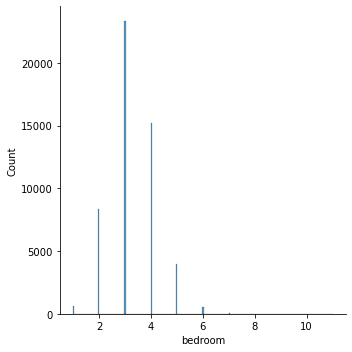

In [54]:
sns.displot(df['bedroom'])
plt.show()

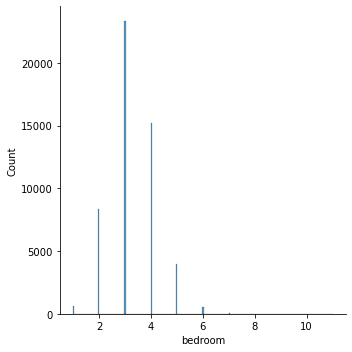

In [50]:
sns.displot(df['bedroom'])
plt.show()

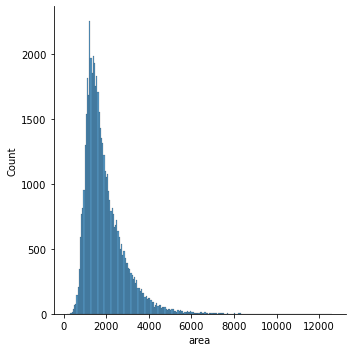

In [51]:
sns.displot(df['area'])
plt.show()

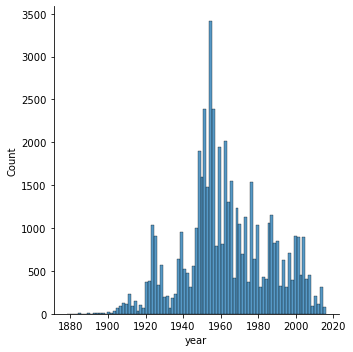

In [52]:
sns.displot(df['year'])
plt.show()

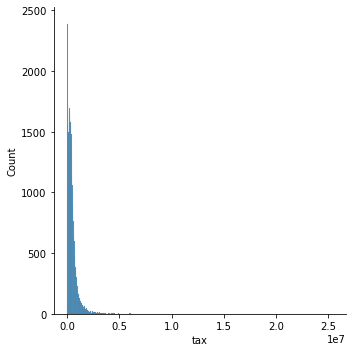

In [53]:
sns.displot(df['tax'])
plt.show()

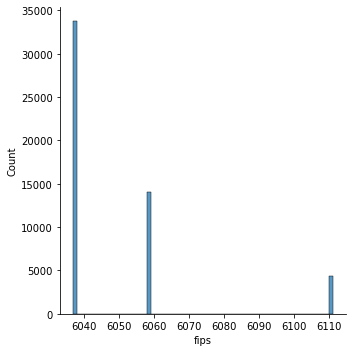

In [55]:
sns.displot(df['fips'])
plt.show()

### Takeaways:
- Similar plots of area and tax
- Normal distribution for bedroom and bathroom
- Three fips 

In [25]:
# separate df by counties
df_6037 = df [df.fips == 6037.0]
df_6059 = df [df.fips == 6059.0]
df_6111 = df [df.fips == 6111.0]

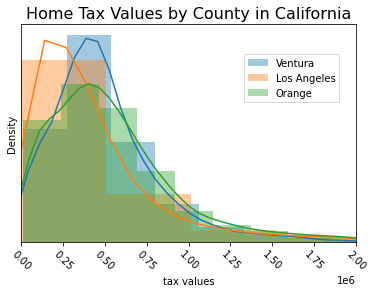

In [26]:
#plot tax distributions by county
plt.title("Home Tax Values by County in California", fontsize=16)

sns.distplot(df_6111.tax, label="Ventura")
sns.distplot(df_6037.tax, label="Los Angeles")
sns.distplot(df_6059.tax, label="Orange")

plt.yticks([])
plt.figlegend(loc = (.65, .65))
plt.xlim(0, 2_000_000)
plt.xlabel('tax values')
plt.xticks(rotation=-45)
plt.show()

In [27]:
# Our target variable
target = 'tax'

In [28]:
def train_validate_test_split(df, target, seed=42):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed)
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed)
    return train, validate, test


In [29]:
train, validate, test = train_validate_test_split(df,target)

In [30]:
# Orginize the data for machine learning
X_train = train.drop(columns=['tax'])
y_train = train.tax

X_validate = validate.drop(columns=['tax'])
y_validate = validate.tax

X_test = test.drop(columns=['tax'])
y_test = test.tax

In [31]:
train.shape, validate.shape, test.shape

((29171, 7), (12503, 7), (10419, 7))

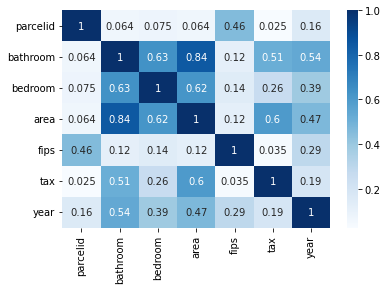

In [32]:
sns.heatmap(train.corr(), cmap='Blues', annot=True)
plt.show()

### Takeaways:
- bedroom and bathroom have the most correlation
- area also plays a big role in tax
- bathroom has the biggest correlation

### Hypothesis Testing:
H0 = there is no difference between county6037(Los Angeles) and county6059(Orange)
Ha = there is a difference between county6037(Los Angeles) and county6059(Orange)

H0 = there is no difference between county6111(Ventura) and county6059(Orange)
Ha = there is a difference between county6111(Ventura) and county6059(Orange)

H0 = there is no difference between county6037(Los Angeles) and county6111(Ventura)
Ha = there is a difference between county6037(Los Angeles) and county6111(Ventura)



In [33]:
# Run a t-test to compare counties to each other
t1, p1 = stats.ttest_ind(df_6037.tax, df_6059.tax)
t2, p2 = stats.ttest_ind(df_6059.tax, df_6111.tax)
t3, p3 = stats.ttest_ind(df_6037.tax, df_6111.tax)
print(f't-score: {t1:.2f}, p-value: {p1:.3f}')
print(f't-score: {t2:.2f}, p-value: {p2:.3f}')
print(f't-score: {t3:.2f}, p-value: {p3:.3f}')

t-score: -17.46, p-value: 0.000
t-score: 8.82, p-value: 0.000
t-score: -2.74, p-value: 0.006


### Takeaways:
The p-value is zero, therefore, the null hypothesis is rejected
The p-value is zero, therefore, the null hypothesis is rejected
The p-value is zero, therefore, the null hypothesis is rejected

### Correlation Test:
H0 = there is no correlation between bathroom and area
Ha = there is a correlation between batroom and area


In [34]:
# Run a correlation test between bathrooms and area
stats.pearsonr(df.bathroom, df.area)

(0.8458623331180443, 0.0)

### Scaling

In [35]:
# MinMax scaler was used
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X_train)
x_train_scaled = scaler.transform(X_train)
x_validate_scaled = scaler.transform(X_validate)
x_test_scaled = scaler.transform(X_test)

### Baseline

In [59]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
value_pred_mean = y_train['tax'].mean()
y_train['value_pred_mean'] = value_pred_mean
y_validate['value_pred_mean'] = value_pred_mean

value_pred_median = y_train['tax'].median()
y_train['value_pred_median'] = value_pred_median
y_validate['value_pred_median'] = value_pred_median

value_pred_mean


511389.85159919097

## Modeling
### Linear Regression Model

In [37]:
lm = LinearRegression(normalize=True)


lm.fit(x_train_scaled, y_train.tax)

# predict train
y_train['value_pred_lm'] = lm.predict(x_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax, y_train.value_pred_lm) ** (1/2)

# predict validate
y_validate['value_pred_lm'] = lm.predict(x_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax, y_validate.value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 4), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 4))

RMSE for OLS using LinearRegression
Training/In-Sample:  476451.104 
Validation/Out-of-Sample:  567336.434


In [38]:
r2_score_ols = r2_score(y_validate.tax, y_validate.value_pred_lm)
round(r2_score_ols, 4)

0.3258

### TweedieRegressor 

In [39]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(x_train_scaled, y_train.tax)

# predict train
y_train['value_pred_glm'] = glm.predict(x_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax, y_train.value_pred_glm) ** (1/2)

# predict validate
y_validate['value_pred_glm'] = glm.predict(x_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax, y_validate.value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", round(rmse_train,4), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 4))

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  476451.104 
Validation/Out-of-Sample:  567336.4307


In [40]:
r2_score_glm = r2_score(y_validate.tax, y_validate.value_pred_glm)
round(r2_score_glm, 4)

0.3258

### Lasso Lars

In [41]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(x_train_scaled, y_train.tax)

# predict train
y_train['value_pred_lars'] = lars.predict(x_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax, y_train.value_pred_lars) ** (1/2)

# predict validate
y_validate['value_pred_lars'] = lars.predict(x_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax, y_validate.value_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train, 4), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,4))

RMSE for Lasso + Lars
Training/In-Sample:  476451.465 
Validation/Out-of-Sample:  567354.0886


In [42]:
r2_score_lars = r2_score(y_validate.tax, y_validate.value_pred_lars)
round(r2_score_lars,4)

0.3257

### Polynomial Regression with power 2

In [43]:
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(x_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(x_validate_scaled)
X_test_degree2 = pf.transform(x_test_scaled)

In [44]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! c
lm2.fit(X_train_degree2, y_train.tax)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax, y_train.value_pred_lm2) ** (1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax, y_validate.value_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", round(rmse_train,4), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,4))


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  463377.7077 
Validation/Out-of-Sample:  553373.8786


In [45]:
r2_score_lm2 = r2_score(y_validate.tax, y_validate.value_pred_lm2)
round(r2_score_lm2, 4)

0.3586

In [46]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['value_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax, y_test.value_pred_lm2) ** (1/2)

print("RMSE for LassoLars Model\nOut-of-Sample Performance: ", round(rmse_test, 4))

RMSE for LassoLars Model
Out-of-Sample Performance:  486824.6684


In [49]:
print(f'Baseline Performance:\nRSME mean: {round(df.tax.mean(), 3)}\nRSME median: {round(df.tax.median(),3)}\n')


print("RMSE for Polynomial Regression Train and Validate Performance:\nTraining/In-Sample: ", round(rmse_train,3), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,3), '\n')

print("RMSE for Polynomial Regression Model Test Performance:\nOut-of-Sample Performance: ", rmse_test)
print(f'The Linear Regession model has an R_squared of {round(r2_score_lm2, 4)}')

Baseline Performance:
RSME mean: 513918.593
RSME median: 372558.0

RMSE for Polynomial Regression Train and Validate Performance:
Training/In-Sample:  463377.708 
Validation/Out-of-Sample:  553373.879 

RMSE for Polynomial Regression Model Test Performance:
Out-of-Sample Performance:  486824.6684132732
The Linear Regession model has an R_squared of 0.3586


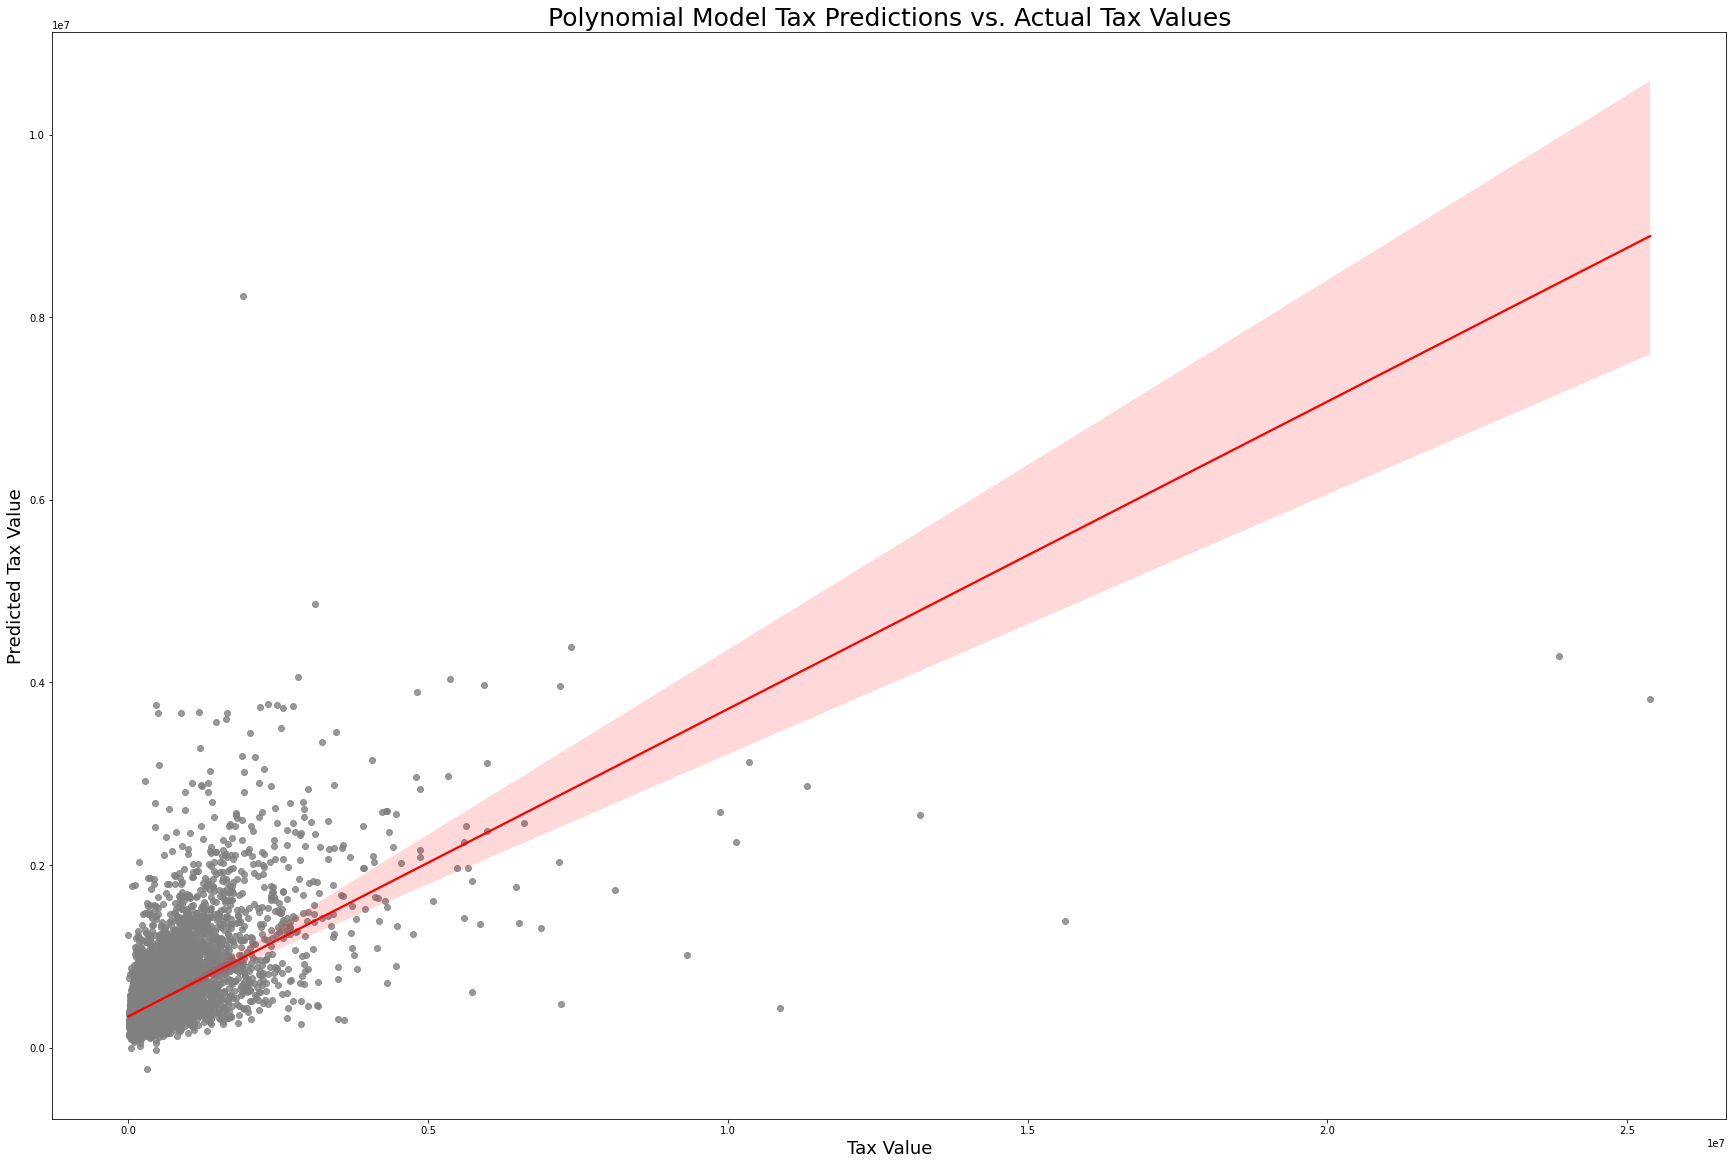

In [48]:
# Plot of the regression model with actual property tax values.
plt.figure(figsize=(30,20))

sns.regplot(data=y_test, x=y_validate.tax, y=y_validate.value_pred_lm2, 
            scatter_kws={'color':'grey'}, line_kws={'color':'red'})

plt.title('Polynomial Model Tax Predictions vs. Actual Tax Values', fontdict={'fontsize':25})
plt.xlabel("Tax Value", fontdict={'fontsize':18})
plt.ylabel("Predicted Tax Value", fontdict={'fontsize':18})
plt.savefig('poly_actual_pred')

### Recommendations:
- The data had too many empty values that were not useful in the modeling. A more complete data could give a better model
- Demographic and socio-economic data can be drivers since people care about the types of neighbors they have.
- Crime data, school district data performance data may also be drivers.
- If I had more time I would split them by counties and see if that imporoves the model